This is my personal use of the cretin frontend. 

In [22]:

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import generator_object, to_generator_string, search, paths, write_run_plot, serial_sim_tools, plt_file, animate #these python files should be in the same folder as cretin_main
for obj in [generator_object, to_generator_string, search, paths, write_run_plot, serial_sim_tools, plt_file, animate]:
    reload(obj)

In [28]:
# first we create our generic object
def sim(var1, var2, var3):

    gen2 = generator_object.User_input()

    rho, T_ev, Tkelvin = 6.9, 30, 512  
    ne, z = 10**20, 12
    N0, N1 = 1, 41 #We are operating in 1d wih 40 nodes
    tin_n = 50
    E1, E2 = 4, 5 # the laser energies
    DN, DR = 10, .1


    gen2.materials_atom(index = 1, quantum_n_max = 3, element= "Sn")
    gen2.materials_region(nodes = [N0, N1], elec_temp = T_ev)
    gen2.materials_region_rho(rho)
    gen2.materials_region_background(ion_density = ne, electron_density = ne, average_charge = z, average_charge_squared=z**2, avg_atomic_number = tin_n )
    gen2.materials_region_element(index = 1, initial_ion_population = ne )

    gen2.geometry(type = 'slab')
    gen2.geometry_nodes(coordinate= "r", scaling_type  = "lin", nodes = [N0, N1], nodes_range=[0,DR])

    gen2.radiation_ebins(n_boundaries = 121, start = 10**-5, end = 10**(5))
    gen2.radiation_angles(n_rays = 3)

    gen2.controls(t_start=0., t_end=3*10**-7, restart = True)

    gen2.sources_source_laser(laser_wavelength = var2, option_1 = 'rate', option_2 = 'history', values = [1,var2], nodes = [N0, N1])
    gen2.sources_source_jnu(E_range = [E1,var3], option_1 = 'rate', option_2 = 'history', nodes = [N0, var1], values = [1,var2])
    gen2.sources_source_jbndry(index = 1, E_range = [E1,var2], option_1 = 'rate', option_2 = 'history', nodes = [1,var2], values=[1,var2])


    gen2.popular_switches(continuum_transfer= 'do steady-state and use integral formalism formalism', timestep_between_snapshot = 3)
    return gen2


i0, iend = 0,2
trials = []
name = 'trial'
for i in range(i0,iend):

    trial = name+str(i)
    trials.append(trial)
    var1 = 3
    var2 = 4**i
    var3 = 1.3
    gen2 = sim(var1, var2, var3)
    #write_run_plot.write(name = name+str(i), object = gen2)
    #write_run_plot.run(name = name+str(i), longprint=False)

#serial_sim_tools.plot_all('trials_mutiplot', trials)

In [29]:
def tin(source, variable):

    gen2 = generator_object.User_input()

    N0, N1 = 1, 121 #number of nodes is 20
    DR =  .1
    TE, rho = 30.0, .002
    E1, E2 = 4.68, 4.68*1.001
    HPEV = 4.135667516e-15
    mult =  HPEV / (E2 - E1)
    RSPOT = .01
    ELASER, TLASER = .06, 2e-9
    ILASER = variable*10**7*ELASER/(TLASER*np.pi*RSPOT**2)
    
    gen2.materials_atom(index = 1, quantum_n_max = 5, element= "sn")    

    gen2.materials_region(nodes = [N0, N1], elec_temp = TE)
    gen2.materials_region_rho(rho)
    gen2.materials_region_element(index = 1, initial_ion_population = 1.)


    gen2.geometry(type = 'slab')
    gen2.geometry_nodes(coordinate= "r", scaling_type  = "lin", nodes = [N0, N1], nodes_range=[0,DR])

    gen2.radiation_ebins(n_boundaries = 101, start = 0.1, end = 10**(2))
    gen2.radiation_angles(n_rays = 3)

    gen2.controls(t_start=0., t_end = 3e-9, restart = True)
    gen2.controls_history(id = 1, value_mutiplier = ILASER, time_multiplier = TLASER)
    gen2.controls_history_tv(time = 0., value = 1)
    gen2.controls_history_tv(time = 1.0, value = 1.)
    gen2.controls_history_tv(time = 1.0, value = 0.)


    gen2.parameters(scattering_muliplier = 0,initial_timestep = 10**-13, minimum_timestep = 10**-14, maximum_timestep = 10**-9, time_between_snapshots=10**(-9))
    gen2.popular_switches(temparture_calc_heating_rates=['temp calc = time dependant','heating rates = electronic'], max_iterations_per_timestep=20)

    gen2.add_plot(name = 'plotter', xvar = 'time', yvar = 'tiv')
    gen2.add_plot(name = 'plotter1', xvar = 'time', yvar = 'tev')
    gen2.add_plot(name = 'plotter2', xvar = 'time', yvar = 'rho')
    gen2.add_plot(name = 'plotter3', xvar = 'time', yvar = 'tev')
    gen2.add_plot(name = 'plotter4', xvar = 'time', yvar = 'zbar')
    gen2.add_plot(name = 'plotter5', xvar = 'time', yvar = 'nion')
    gen2.add_plot(name = 'plotter6', xvar = 'time', yvar = 'ne')

    if source == 'SOURCE1':
        gen2.sources_source_laser(laser_wavelength = 4, option_1= 'rate', option_2= 'history', values = [1,1], nodes= [N0, N1])

    elif source == 'SOURCE2':
        gen2.sources_source_jnu(E_range=[E1,E2], option_1= 'rate', option_2= 'history', values = [1,mult], nodes= [N0, N1])

    elif source == 'SOURCE3':
        gen2.sources_source_jbndry(index = 1, E_range= [E1, E2], option_1= 'rate', option_2= 'history',values = [1,mult])
        gen2.sources_boundary(package='radiation', type = 'streaming', nodes= [1, 0, N1, 'xfile'], value = 1, mult = mult)
        gen2.popular_switches(temparture_calc_heating_rates=['temp calc = time dependant','heating rates = electronic'], 
                              max_iterations_per_timestep = 10, continuum_transfer='do steady-state and use integral formalism formalism')
        
    elif source == 'SOURCE4':
        gen2.sources_source_jbndry(index = 1, E_range= [E1, E2], option_1= 'rate', option_2= 'history',values = [1,mult])
        gen2.sources_boundary(package='radiation', type = 'streaming', nodes= [1, 0, N1, 'xfile'], value = 1, mult = mult)
        gen2.popular_switches(continuum_transfer_evolves_temp = True)
        gen2.sources_rswitch(radiation_transfer_algorithm1d= 'do transport using integral formalism', assume_NLTE= True)  
    
    return gen2


i0 = 0
trials = []
name = 'trial'
N, M = 6, 2 # this is the multiplot group size and number of groups
iend = 1

for i in range(i0,iend):
    name_i = name+str(i)
    trials.append(name_i)
    variable = 2**(i/2)
    gen2 = tin('SOURCE1', variable)

    #write_run_plot.write(name = name_i, object = gen2)
    #write_run_plot.run(name = name_i, longprint=False)

    if (i>0 and i%N == 0):
        #serial_sim_tools.plot_all(f'trials_mutiplot{int(i/N)}', trials)
        trials = []

    elif i == iend -1:
        #serial_sim_tools.plot_all(f'trials_mutiplot{int(i/N)+1}', trials)
        pass

In [32]:
def sim(var1):

    gen = generator_object.User_input()
    n_atom = 50
    rho, T_ev = 6.9, var1/11600
    z = 11
    N0, N1 = 1, 501 #We are operating in 1d wih 40 nodes
    Rmin, Rmax = 0, 0.01
    p2 = 1.e-9


    gen.materials_atom(index = 1, quantum_n_max = 3, element= "sn")  
    gen.materials_region(nodes = [N0, N1], elec_temp = T_ev, qstart = True) 

    gen.materials_region_material(rho, n_atom, z, z**2) #

    gen.geometry(type = 'slab')
    gen.geometry_nodes(coordinate = "r", scaling_type  = "geom", nodes = [N0, N1], nodes_range = [Rmin, Rmax], drmin = 1.e-6, slope = -1)


    gen.sources_laser(index = 1, laser_wavelength = 1, option_1= 'value', option_2= 'history', id_value = 1, multiplier=1,)
    gen.sources_lasray(entrance_position =  10, entrance_direction_mu = 1, entrance_direction_phi = 0, fractional_power= 1, res_frac=.5)
    
    gen.sources_history(id = 1, value_multiplier = 1e18, time_multiplier = 1., pulse_type='gaussian', p1 = 5*p2, p2 = p2)

    gen.popular_switches(timestep_between_snapshot = 100, 
                        temparture_calc_heating_rates = ['temp calc = time dependant', 'heating rates = electronic'], 
                        raytrace = True, 
                        include_degeneracy = 'no degeneracy',
                        continuum_transfer_evolves_temp = True)

        
    gen.other_switches(resonant_absrption_fraction = 'constant value for each ray from lasray', 
                        subcycle_maximum = 1000,
                        do_kinetics_zone_centerd = True, 
                        population_calculation = 'time dependent diffusion', 
                        control_calc_thermal_conduct = 'include thermal conduction')
    
    gen.controls(t_start = 0, t_end = 2.e-8, restart = True)

    gen.parameters(time_between_snapshots = 1e-9, initial_timestep = 1.e-14)
    
    return gen

var1_ops = np.arange(100,1000,100., dtype=float)

sims = []


for entry in var1_ops:
    name = f'simrun_{entry}'
    sims.append(name)
    gen = sim(entry)

    #write_run_plot.write(name, object = gen)
    #write_run_plot.run(name, longprint = False)

serial_sim_tools.plot_all('sims_multiplot', sims)



multiplot to /home/brewster/Desktop/cretin_package-master/Personal_experiments/sims_multiplot


(22,)
(22,)
(22,)
(22,)
(22,)
(22,)
(22,)
(21,)
(21,)


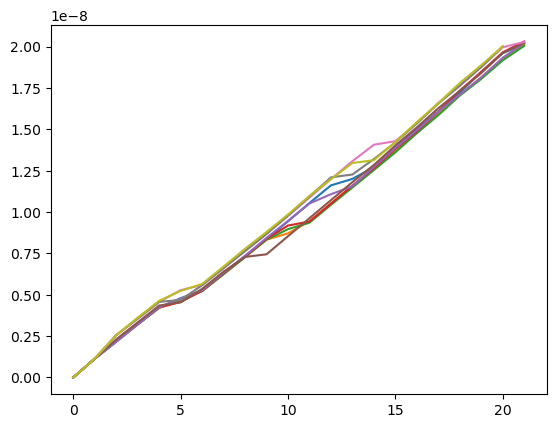

In [31]:
# If you would like to have a look at the raw data produced by the dump file
lis =[]
for foldername in sims:
    loc = f'{paths.to_personal_data()}{foldername}/{foldername}.d00'
    data = serial_sim_tools.savedict(loc)
    lis.append(data['times'])

#are_all_arrays_close = all(np.allclose(arr, lis[0]) for arr in lis if arr.shape == lis[0].shape)
#print(are_all_arrays_close)
for entry in lis:
    print(entry.shape)


fig, ax = plt.subplots()

# Plot each array (vector) in the list
for arr in lis:
    ax.plot(arr)


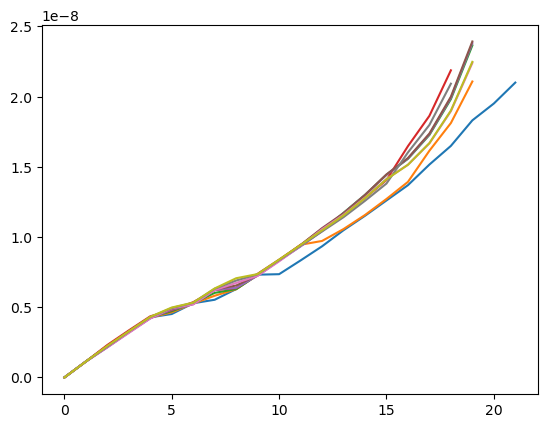

Findings sofar:

"Zone centered" made little diffrence. moving on to qstart.

"qstart" makes enormous diffrence, datasets incomparable resuming with qstart = True.

"quantum n_max" seems to make little diffrence, resuming with n_max = 3.

The 'gaussian' option seems to be vital to produce output in gen.sources_history command resuming with gaussian options from ablate.gen

